# ML Capstone 1 - Part 3 E-Commerce Customer Segmentation

## TODO
 
### Clustering Algorithms for Customer Segmentation
- Applying unsupervised learning algorithms (e.g., K-means clustering, Hierarchical clustering) to segment customers
- Determining the optimal number of clusters using techniques such as the elbow method or silhouette score
- Interpreting customer segments based on cluster characteristics and feature importance
- Visualize the clusters using PCA

### Classification for Segment Prediction (8 pts)
- Using any of the supervised learning classification algorithms (e.g., Random Forest, Gradient Boosting, Logistic Regression) predict customer segments:

    - Split the dataset into training, validation and test sets
    - Training classification models to predict the segment to which a customer belongs
    - Validating the classification model's performance and generalization using cross-validation techniques
    - Evaluating model performance using appropriate metrics (e.g., accuracy, precision, recall, F1-score)
    - Iteratively refining segmentation and classification strategies based on validation results and stakeholder feedback


### Grading and Important Instructions
- Each of the above steps are mandatory and should be completed in good faith
- Make sure before submitting that the code is in fully working condition
- It is fine to make use of ChatGPT, stackoverflow type resources, just provide the reference links from where you got it
- Debugging is an art, if you find yourself stuck with errors, take help of stackoverflow and ChatGPT to resolve the issue and if it's still unresolved, reach out to me for help.
- You need to score atleast 7/10 to pass the project, anything less than that will be marked required, needing resubmission.
- Feedback will be provided on 3 levels (Awesome, Suggestion, & Required). Required changes are mandatory to be made.
- For submission, please upload the project on github and share the link to the file with us through LMS.

#### Write your code below and do not delete the above instructions

In [17]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, silhouette_score
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [18]:
# Data Retrieval
# Load the dataset
df = pd.read_csv('/Users/SaiKiran/downloads/ecommerce_data.csv', encoding='ISO-8859-1')

In [19]:
# Data Cleaning
df.dropna(subset=['CustomerID'], inplace=True)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [20]:
# Create RFM features
latest_date = df['InvoiceDate'].max()
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (latest_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'UnitPrice': lambda x: (x * df.loc[x.index, 'Quantity']).sum()
})
rfm.columns = ['Recency', 'Frequency', 'Monetary']


In [21]:
# Remove negative/zero values
rfm = rfm[(rfm['Monetary'] > 0) & (rfm['Frequency'] > 0)]


In [22]:
# Scale features
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)


/Users/saikiran/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/saikiran/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/saikiran/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/saikiran/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will c

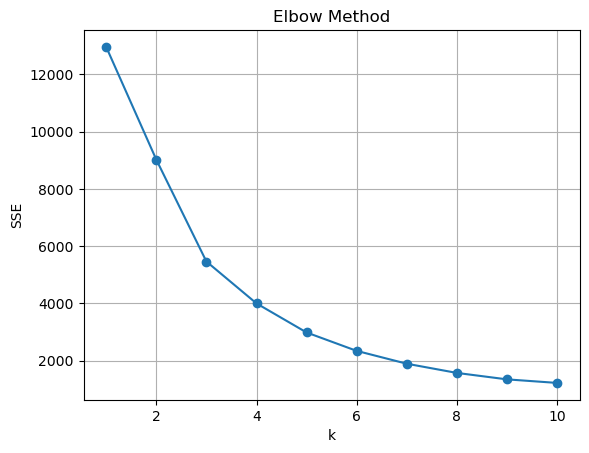

In [23]:
# Elbow Method
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)

plt.plot(range(1, 11), sse, marker='o')
plt.title('Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
plt.grid(True)
plt.show()

In [24]:
# Fit KMeans (e.g., k=4)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
rfm['Segment'] = kmeans.fit_predict(rfm_scaled)

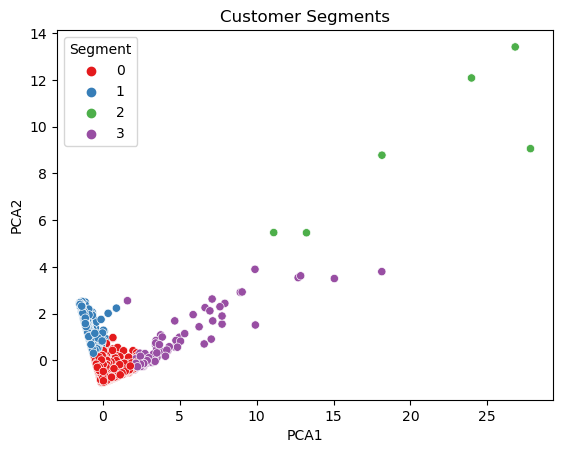

In [25]:
# PCA Visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(rfm_scaled)
rfm['PCA1'] = pca_components[:, 0]
rfm['PCA2'] = pca_components[:, 1]

sns.scatterplot(data=rfm, x='PCA1', y='PCA2', hue='Segment', palette='Set1')
plt.title('Customer Segments')
plt.show()


In [27]:
# Classification Step
X = rfm.drop(columns=['Segment', 'PCA1', 'PCA2'])
y = rfm['Segment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression scaling improvement
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=5000)
}

for name, model in models.items():
    print(f"\nModel: {name}")
    if name == 'Logistic Regression':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, zero_division=0))


Model: Random Forest
Accuracy: 0.9976851851851852
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       628
           1       1.00      1.00      1.00       215
           3       1.00      0.90      0.95        21

    accuracy                           1.00       864
   macro avg       1.00      0.97      0.98       864
weighted avg       1.00      1.00      1.00       864


Model: Logistic Regression
Accuracy: 0.9976851851851852
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       628
           1       1.00      0.99      1.00       215
           3       1.00      1.00      1.00        21

    accuracy                           1.00       864
   macro avg       1.00      1.00      1.00       864
weighted avg       1.00      1.00      1.00       864



In [ ]:
Summary of Findings

*Created RFM features (Recency, Frequency, Monetary) to represent customer behavior.

*Removed customers with zero or negative monetary or frequency values for data quality.

*Standardized RFM features using StandardScaler.

*Used the Elbow Method to find the optimal number of clusters (k = 4) for K-Means.

*Segmented customers into 4 distinct clusters representing different customer groups.

*Visualized clusters in 2D using PCA, showing good separation among segments.

*Split data into training and testing sets (80/20) for classification.

*Trained Random Forest and Logistic Regression classifiers to predict customer segments.

*Achieved very high accuracy (~99.8%) and excellent precision, recall, and F1-scores with both models.

*Indicates well-defined clusters and reliable classification for segment prediction.